# We are going to use the following Data Science Framework
# This notebook completes 2-4 of the framework
- We will use this dataset to do a number of investigations so will not define the problem just yet

## A Data Science Framework - Taken from Popular Kaggle Notebook

1. **Define the Problem:** If data science, big data, machine learning, predictive analytics, business intelligence, or any other buzzword is the solution, then what is the problem? As the saying goes, don't put the cart before the horse. Problems before requirements, requirements before solutions, solutions before design, and design before technology. Too often we are quick to jump on the new shiny technology, tool, or algorithm before determining the actual problem we are trying to solve.
2. **Gather the Data:** John Naisbitt wrote in his 1984 (yes, 1984) book Megatrends, we are “drowning in data, yet staving for knowledge." So, chances are, the dataset(s) already exist somewhere, in some format. It may be external or internal, structured or unstructured, static or streamed, objective or subjective, etc. As the saying goes, you don't have to reinvent the wheel, you just have to know where to find it. In the next step, we will worry about transforming "dirty data" to "clean data."
3. **Prepare Data for Consumption:** This step is often referred to as data wrangling, a required process to turn “wild” data into “manageable” data. Data wrangling includes implementing data architectures for storage and processing, developing data governance standards for quality and control, data extraction (i.e. ETL and web scraping), and data cleaning to identify aberrant, missing, or outlier data points.
4. **Perform Exploratory Analysis:** Anybody who has ever worked with data knows, garbage-in, garbage-out (GIGO). Therefore, it is important to deploy descriptive and graphical statistics to look for potential problems, patterns, classifications, correlations and comparisons in the dataset. In addition, data categorization (i.e. qualitative vs quantitative) is also important to understand and select the correct hypothesis test or data model.
5. **Model Data:** Like descriptive and inferential statistics, data modeling can either summarize the data or predict future outcomes. Your dataset and expected results, will determine the algorithms available for use. It's important to remember, algorithms are tools and not magical wands or silver bullets. You must still be the master craft (wo)man that knows how-to select the right tool for the job. An analogy would be asking someone to hand you a Philip screwdriver, and they hand you a flathead screwdriver or worst a hammer. At best, it shows a complete lack of understanding. At worst, it makes completing the project impossible. The same is true in data modelling. The wrong model can lead to poor performance at best and the wrong conclusion (that’s used as actionable intelligence) at worst.
6. **Validate and Implement Data Model:** After you've trained your model based on a subset of your data, it's time to test your model. This helps ensure you haven't overfit your model or made it so specific to the selected subset, that it does not accurately fit another subset from the same dataset. In this step we determine if our [model overfit, generalize, or underfit our dataset](http://docs.aws.amazon.com/machine-learning/latest/dg/model-fit-underfitting-vs-overfitting.html).
7. **Optimize and Strategize:** This is the "bionic man" step, where you iterate back through the process to make it better...stronger...faster than it was before. As a data scientist, your strategy should be to outsource developer operations and application plumbing, so you have more time to focus on recommendations and design. Once you're able to package your ideas, this becomes your “currency exchange" rate.

# 2. Gather Data 

We will use three datasets in our forecoming analyses
1. Traffic_Flow_Data_Jan_to_June_2022_SDCC.csv: Has information on traffic flow at various locations
2. Traffic_Data_Site_Names_SDCC.csv: Gives more information on the locations the traffic flow data is being collected from
3. historical_weather_data_phoenix_park.csv: Has weather data from Phoenix park from the same time period as the traffic flow

## Imports

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import contextily as ctx
import folium
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go

## 2.1 Traffic Flow Data
Two csv files are available:
1. Traffic_Flow_Data_Jan_to_June_2022_SDCC.csv: Has information on traffic flow at various locations
2. Traffic_Data_Site_Names_SDCC.csv: Gives more information on the locations the traffic flow data is being collected from


In [2]:
traffic_flow_data = pd.read_csv('data/Traffic_Flow_Data_Jan_to_June_2022_SDCC.csv')
traffic_junctions_data = pd.read_csv('data/Traffic_Data_Site_Names_SDCC.csv')

### 2.1.1 Traffic_Flow_Data_Jan_to_June_2022_SDCC

In [3]:
traffic_flow_data.head()

,site,day,date,start_time,end_time,flow,flow_pc,cong,cong_pc,dsat,dsat_pc,ObjectId
0,N01111A,TU,04/01/2022,2022/11/07 03:00:00+00,03:15,13,100,0,100,0,0,1
1,N01111A,TU,04/01/2022,2022/11/07 03:15:00+00,03:30,10,100,0,100,0,0,2
2,N01111A,TU,04/01/2022,2022/11/07 03:30:00+00,03:45,0,100,0,100,0,0,3
3,N01111A,TU,04/01/2022,2022/11/07 03:45:00+00,04:00,9,100,0,100,0,0,4
4,N01111A,TU,04/01/2022,2022/11/07 04:00:00+00,04:15,0,100,0,100,0,0,5


In [4]:
print(f'Dataset has {len(traffic_flow_data):,} rows')

Dataset has 1,048,575 rows


### Columns explanations
1. "site": This is the ID of the site at which the congestion was collected (More information on these sites given in the second dataset)
2. "day": This is the day on which the data was collected
3. "date" This is the date on which the the data was collected
4. "start_time": Congestion is collected over 15 minute intervals. This is the start time of this 15 minute interval
5. "end_time": Congestion is collected over 15 minute intervals. This is the end time of this 15 minute interval
6. "flow": Represents the demand (traffic flow) at each site. This is calculated by the SCOOT model, which measures the volume of traffic over several minutes. It has two profiles:
    - Short: Raw data showing real-time values over the last few minutes.
    - Long: Smoothed average values over a longer period. The system uses the appropriate profile depending on the situation.
7. "cong": Measures congestion by detecting standing traffic. When stationary traffic is detected for an entire interval, it is considered a congested interval. The system records how many intervals experienced congestion in a cycle.
8. "cong_pc": The percentage of congestion, calculated based on the number of congested intervals relative to the total cycle time. This gives an idea of how much of the time the site was congested.
9. "dsat": Degree of saturation, which is the ratio of the actual traffic demand flow to the maximum possible discharge flow (saturation flow). It indicates how full the traffic system is. The Split optimizer tries to minimize the maximum degree of saturation on links approaching the node.
10. "dsat_pc": Likely represents the degree of saturation as a percentage, giving a proportional view of how saturated a site is relative to its maximum capacity.
11. "ObjectId": Each data entry is given a unique ID

Some end times are "24:00" instead of "00:00: so this must be fixed

In [5]:
mask_24h = traffic_flow_data['end_time'].str.contains('24:00')
traffic_flow_data.loc[mask_24h, 'end_time'] = '00:00'
traffic_flow_data['end_time'] = pd.to_datetime(traffic_flow_data['end_time']).dt.time


/var/folders/5g/y4dx7m714l7ft2p__s3ybpn80000gn/T/ipykernel_20631/4131929773.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  traffic_flow_data['end_time'] = pd.to_datetime(traffic_flow_data['end_time']).dt.time


- SCOOT (Split Cycle Offset Optimization Technique) is a traffic control system used for real-time optimization of traffic signals in urban areas. See more on wikipedia https://en.wikipedia.org/wiki/Split_Cycle_Offset_Optimisation_Technique 

### 2.1.2 Traffic_Data_Site_Names_SDCC
This file has more information on the sites Traffic_Flow_Data_Jan_to_June_2022_SDCC
-  <b> Key point: We only have data from system A -> Just use sites that end in A from traffic flows </b>
- lets then create a column for the sites we have available in this dataset

In [6]:
traffic_junctions_data['site'] = traffic_junctions_data['scn']+traffic_junctions_data['system']
traffic_junctions_data.head()

,OBJECTID,scn,region,system,locn,X,Y,site
0,1,N01111,RGA,A,Airton GrHill,-6.356151,53.293594,N01111A
1,2,N01121,RGR,A,Mayberry GrHill,-6.354352,53.298306,N01121A
2,3,N01131,RGR,A,Tymon North,-6.352204,53.301229,N01131A
3,4,N01141,RGR,A,Cuckoos Nest,-6.352882,53.303248,N01141A
4,5,N01151,RGA,A,Harvey Grhills,-6.355703,53.294523,N01151A


Get the common sites available via an inner join

In [7]:
traffic_junctions_data['site'] = traffic_junctions_data['site'].astype(str)
traffic_flow_data['site'] = traffic_flow_data['site'].astype(str)

merged_data = traffic_junctions_data.merge(traffic_flow_data, on='site', how='inner')
merged_data.drop(columns=['OBJECTID', 'ObjectId', 'system'], inplace=True)
merged_data.head()

,scn,region,locn,X,Y,site,day,date,start_time,end_time,flow,flow_pc,cong,cong_pc,dsat,dsat_pc
0,N01111,RGA,Airton GrHill,-6.356151,53.293594,N01111A,TU,04/01/2022,2022/11/07 03:00:00+00,03:15:00,13,100,0,100,0,0
1,N01111,RGA,Airton GrHill,-6.356151,53.293594,N01111A,TU,04/01/2022,2022/11/07 03:15:00+00,03:30:00,10,100,0,100,0,0
2,N01111,RGA,Airton GrHill,-6.356151,53.293594,N01111A,TU,04/01/2022,2022/11/07 03:30:00+00,03:45:00,0,100,0,100,0,0
3,N01111,RGA,Airton GrHill,-6.356151,53.293594,N01111A,TU,04/01/2022,2022/11/07 03:45:00+00,04:00:00,9,100,0,100,0,0
4,N01111,RGA,Airton GrHill,-6.356151,53.293594,N01111A,TU,04/01/2022,2022/11/07 04:00:00+00,04:15:00,0,100,0,100,0,0


## 2.2. Weather Conditions
- another factor that comes to mind that could influence traffic would be the weather! Whether that's people driving slower on icy roads or a big rush to drive to the sea on a sunny day, the weather 
definitely has influenced traffic patterns in my own personal experience
- I have downloaded a dataset of weather conditions from Met Eireann: https://www.met.ie/climate/available-data/historical-data

In [8]:
# Read in from CSV file
weather_data = pd.read_csv('data/historical_weather_phoenix_park.csv')
weather_data.head()

/var/folders/5g/y4dx7m714l7ft2p__s3ybpn80000gn/T/ipykernel_20631/2529781008.py:2: DtypeWarning: Columns (2,4,6,7,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  weather_data = pd.read_csv('data/historical_weather_phoenix_park.csv')


,date,ind,rain,ind.1,temp,ind.2,wetb,dewpt,vappr,rhum,msl
0,16-aug-2003 01:00,0,0.0,0,9.2,0,8.9,8.5,11.1,95,1021.9
1,16-aug-2003 02:00,0,0.0,0,9.0,0,8.7,8.5,11.1,96,1021.7
2,16-aug-2003 03:00,0,0.0,0,8.2,0,8.0,7.7,10.5,96,1021.2
3,16-aug-2003 04:00,0,0.0,0,8.4,0,8.1,7.9,10.7,97,1021.2
4,16-aug-2003 05:00,0,0.0,0,7.7,0,7.5,7.3,10.2,97,1021.1


Column name meanings


| **Date and Time (UTC)** | **Precipitation Amount (mm)** | **Air Temperature (°C)** | **Wet Bulb Temperature (°C)** | **Dew Point Temperature (°C)** | **Vapour Pressure (hPa)** | **Relative Humidity (%)** | **Mean Sea Level Pressure (hPa)** | **Indicator** |
|------------------------|-------------------------------|--------------------------|-------------------------------|--------------------------------|--------------------------|---------------------------|----------------------------------|---------------|
| date                   | rain                          | temp                     | wetb                          | dewpt                         | vappr                    | rhum                      | msl                              | ind           |


## 2.3 Merge Traffic and Weather Data 

### 2.3.1 Read weather data date column as date time

In [9]:
# Convert date columns to date time
weather_data['date'] = pd.to_datetime(weather_data['date'], format='mixed')

- Weather is recorded every hour and the traffic is recorded every 15 minutes
- We decide that half an hour intervals are a period of interest so that is the dataset we will create

### 2.3.2 Convert traffic flow dataset to half hourly intervals

First convert date columns to date time

In [16]:
merged_data['date'] = pd.to_datetime(merged_data['date'], format='mixed')

merged_data['start_time'] = pd.to_datetime(merged_data['start_time'])
merged_data['start_time'] = merged_data['start_time'].dt.time
merged_data['start_time'] = pd.to_datetime(merged_data['start_time'], format='mixed')


TypeError: <class 'datetime.time'> is not convertible to datetime, at position 0

In [17]:
merged_data

,scn,region,locn,X,Y,site,day,date,start_time,end_time,flow,flow_pc,cong,cong_pc,dsat,dsat_pc
0,N01111,RGA,Airton GrHill,-6.356151,53.293594,N01111A,TU,2022-04-01,03:00:00,03:15:00,13,100,0,100,0,0
1,N01111,RGA,Airton GrHill,-6.356151,53.293594,N01111A,TU,2022-04-01,03:15:00,03:30:00,10,100,0,100,0,0
2,N01111,RGA,Airton GrHill,-6.356151,53.293594,N01111A,TU,2022-04-01,03:30:00,03:45:00,0,100,0,100,0,0
3,N01111,RGA,Airton GrHill,-6.356151,53.293594,N01111A,TU,2022-04-01,03:45:00,04:00:00,9,100,0,100,0,0
4,N01111,RGA,Airton GrHill,-6.356151,53.293594,N01111A,TU,2022-04-01,04:00:00,04:15:00,0,100,0,100,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104232,N03121,ROR,N4 Off Ramp EB,-6.424314,53.357202,N03121A,WE,2022-06-29,16:30:00,16:45:00,367,100,0,100,27,96
104233,N03121,ROR,N4 Off Ramp EB,-6.424314,53.357202,N03121A,WE,2022-06-29,16:45:00,17:00:00,391,100,0,100,30,96
104234,N03121,ROR,N4 Off Ramp EB,-6.424314,53.357202,N03121A,WE,2022-06-29,17:00:00,17:15:00,444,100,0,100,33,96
104235,N03121,ROR,N4 Off Ramp EB,-6.424314,53.357202,N03121A,WE,2022-06-29,17:15:00,17:30:00,402,100,0,100,30,98


Group the data into half hourly intervals

In [14]:
# Round the start_time to the nearest half-hour
merged_data['start_time'] = merged_data['start_time'].dt.round('30min')

# Extract half-hour intervals (0 for the hour, 30 for half past)
merged_data['time_(half_hour)'] = merged_data['start_time'].dt.strftime('%H:%M')

# Group by the new half-hour intervals along with other specified columns
merged_data = merged_data.groupby(['time_(half_hour)', 'start_time', 'site', 'day', 'date', 'X', 'Y']).agg({'flow': 'sum', 'cong':'sum'}).reset_index()

print(f'Dataset now has {len(merged_data):,} rows after filtering to relevant sites and aggregating data by half hour')

AttributeError: Can only use .dt accessor with datetimelike values

Create date time column that combines date and time

In [13]:
merged_data['datetime'] = merged_data['date'].astype(str)+' ' + merged_data['time_(half_hour)'].astype(str)
merged_data['datetime'] = pd.to_datetime(merged_data['datetime'])

# Create rounded datetime for joining
merged_data['rounded_datetime'] = merged_data['datetime'].dt.round('h')
merged_data['rounded_datetime'] = pd.to_datetime(merged_data['rounded_datetime'])

### 2.3.3 Join the weather data onto the traffic dataset to create main 'df' dataset

In [29]:

# Remove date column in weather data before join
df2_filtered = weather_data.drop(columns=['date'])
df = merged_data.merge(df2_filtered, left_on='rounded_datetime', right_on=weather_data['date'], how='left')
df = df.sort_values(by=['site', 'datetime'])
df.head()

,time_(half_hour),start_time,site,day,date,X,Y,flow,cong,datetime,...,ind,rain,ind.1,temp,ind.2,wetb,dewpt,vappr,rhum,msl
51,00:00,2022-11-07 00:00:00+00:00,N01111A,SA,2022-01-01,-6.356151,53.293594,116,0,2022-01-01 00:00:00,...,0,0.0,0,13.1,0,11.4,9.8,12.1,80,1007.3
1137,00:00,2022-11-08 00:00:00+00:00,N01111A,SA,2022-01-01,-6.356151,53.293594,46,0,2022-01-01 00:00:00,...,0,0.0,0,13.1,0,11.4,9.8,12.1,80,1007.3
2223,00:30,2022-11-07 00:30:00+00:00,N01111A,SA,2022-01-01,-6.356151,53.293594,95,0,2022-01-01 00:30:00,...,0,0.0,0,13.1,0,11.4,9.8,12.1,80,1007.3
3309,01:00,2022-11-07 01:00:00+00:00,N01111A,SA,2022-01-01,-6.356151,53.293594,193,0,2022-01-01 01:00:00,...,0,0.0,0,13.9,0,11.2,8.5,11.1,70,1005.8
4395,01:30,2022-11-07 01:30:00+00:00,N01111A,SA,2022-01-01,-6.356151,53.293594,41,0,2022-01-01 01:30:00,...,0,0.0,0,14.0,0,11.0,8.1,10.8,67,1005.0


Ensure no null entries in this dataframe

In [30]:
null_rows = df[df.isnull().any(axis=1)]
# Display the first few rows with null values
null_rows

,time_(half_hour),start_time,site,day,date,X,Y,flow,cong,datetime,...,ind,rain,ind.1,temp,ind.2,wetb,dewpt,vappr,rhum,msl


# 3. Prepare Data for Consumption
## The 4 C's of Data Cleaning: Correcting, Completing, Creating, and Converting
In this stage, we will clean our data by 1) correcting aberrant values and outliers, 2) completing missing information, 3) creating new features for analysis, and 4) converting fields to the correct format for calculations and presentation.

1. **Correcting:** Check for incorrect data
2. **Completing:** Handling Null Values
3. **Creating:**  Feature engineering 
4. **Converting:** Obtain correct data types for data

## 3.1 Correcting

start_time column is now redundant so we can remove that

In [31]:
if 'start_time' in df.columns:
    df.drop(columns=['start_time'], inplace=True)

Remove any duplicates that appeared following the data merging

In [34]:
df

,time_(half_hour),site,day,date,X,Y,flow,cong,datetime,rounded_datetime,ind,rain,ind.1,temp,ind.2,wetb,dewpt,vappr,rhum,msl
51,00:00,N01111A,SA,2022-01-01,-6.356151,53.293594,116,0,2022-01-01 00:00:00,2022-01-01 00:00:00,0,0.0,0,13.1,0,11.4,9.8,12.1,80,1007.3
1137,00:00,N01111A,SA,2022-01-01,-6.356151,53.293594,46,0,2022-01-01 00:00:00,2022-01-01 00:00:00,0,0.0,0,13.1,0,11.4,9.8,12.1,80,1007.3
2223,00:30,N01111A,SA,2022-01-01,-6.356151,53.293594,95,0,2022-01-01 00:30:00,2022-01-01 00:00:00,0,0.0,0,13.1,0,11.4,9.8,12.1,80,1007.3
3309,01:00,N01111A,SA,2022-01-01,-6.356151,53.293594,193,0,2022-01-01 01:00:00,2022-01-01 01:00:00,0,0.0,0,13.9,0,11.2,8.5,11.1,70,1005.8
4395,01:30,N01111A,SA,2022-01-01,-6.356151,53.293594,41,0,2022-01-01 01:30:00,2022-01-01 02:00:00,0,0.0,0,14.0,0,11.0,8.1,10.8,67,1005.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48785,21:30,N03121A,SU,2022-12-06,-6.424314,53.357202,106,0,2022-12-06 21:30:00,2022-12-06 22:00:00,0,0.0,0,3.2,0,2.7,1.7,6.9,89,1028.3
49871,22:00,N03121A,SU,2022-12-06,-6.424314,53.357202,419,0,2022-12-06 22:00:00,2022-12-06 22:00:00,0,0.0,0,3.2,0,2.7,1.7,6.9,89,1028.3
50957,22:30,N03121A,SU,2022-12-06,-6.424314,53.357202,130,0,2022-12-06 22:30:00,2022-12-06 22:00:00,0,0.0,0,3.2,0,2.7,1.7,6.9,89,1028.3
52043,23:00,N03121A,SU,2022-12-06,-6.424314,53.357202,229,0,2022-12-06 23:00:00,2022-12-06 23:00:00,0,0.0,0,3.5,0,2.8,1.8,6.9,88,1028.3


In [32]:
duplicate_rows = df[df.duplicated(subset=['datetime', 'site'], keep=False)]
duplicate_rows

,time_(half_hour),site,day,date,X,Y,flow,cong,datetime,rounded_datetime,ind,rain,ind.1,temp,ind.2,wetb,dewpt,vappr,rhum,msl
51,00:00,N01111A,SA,2022-01-01,-6.356151,53.293594,116,0,2022-01-01,2022-01-01,0,0.0,0,13.1,0,11.4,9.8,12.1,80,1007.3
1137,00:00,N01111A,SA,2022-01-01,-6.356151,53.293594,46,0,2022-01-01,2022-01-01,0,0.0,0,13.1,0,11.4,9.8,12.1,80,1007.3
129,00:00,N01111A,TU,2022-01-02,-6.356151,53.293594,65,0,2022-01-02,2022-01-02,0,0.0,0,9.8,0,8.6,7.2,10.2,84,1005.5
1215,00:00,N01111A,TU,2022-01-02,-6.356151,53.293594,30,0,2022-01-02,2022-01-02,0,0.0,0,9.8,0,8.6,7.2,10.2,84,1005.5
130,00:00,N01111A,TU,2022-01-03,-6.356151,53.293594,70,0,2022-01-03,2022-01-03,0,0.0,0,8.6,0,6.8,4.5,8.4,75,1003.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2145,00:00,N03121A,TU,2022-12-04,-6.424314,53.357202,81,0,2022-12-04,2022-12-04,0,0.1,0,3.7,0,3.4,2.9,7.5,94,1020.0
1033,00:00,N03121A,TH,2022-12-05,-6.424314,53.357202,123,0,2022-12-05,2022-12-05,0,0.0,0,7.4,0,5.6,3.0,7.6,73,1022.9
2119,00:00,N03121A,TH,2022-12-05,-6.424314,53.357202,74,0,2022-12-05,2022-12-05,0,0.0,0,7.4,0,5.6,3.0,7.6,73,1022.9
1007,00:00,N03121A,SU,2022-12-06,-6.424314,53.357202,223,0,2022-12-06,2022-12-06,0,0.1,0,6.4,0,5.3,3.9,8.1,84,1028.3


## Merged Data

### Understand the sites

In [ ]:
pd.DataFrame(merged_data['site'].value_counts())

,count
site,
N01111A,13917
N01151A,13917
N02111A,13917
N02131A,13917
N03121A,13917
N01131A,13916


Let's have a look on the map at these locations

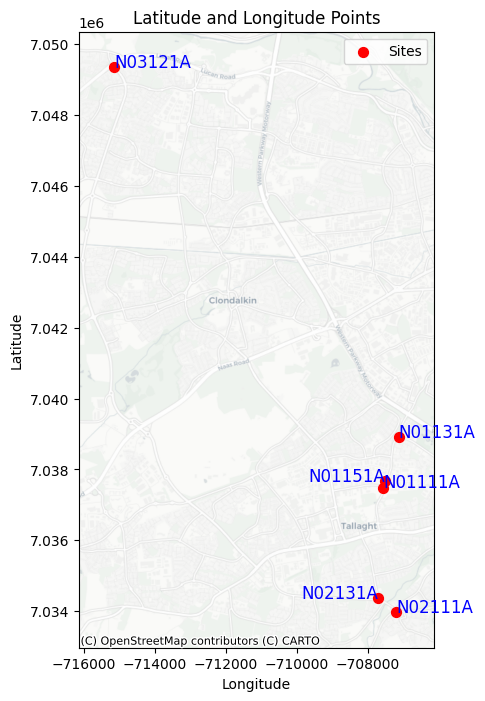

In [ ]:
# Create the DataFrame
unique_locations = merged_data[['X', 'Y', 'site']].drop_duplicates()

df = pd.DataFrame(unique_locations)

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['X'], df['Y']))

# Set the coordinate reference system to WGS84 (EPSG:4326)
gdf.set_crs(epsg=4326, inplace=True)

# Convert to Web Mercator for basemap
gdf = gdf.to_crs(epsg=3857)

# Create a plot
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the points
gdf.plot(ax=ax, color='red', markersize=50, label='Sites')

# Add a basemap using contextily
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron)

# Set title and labels
plt.title("Latitude and Longitude Points")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Zoom out by adjusting the limits
x_buffer = 1e3  # Adjust this value for more or less zoom out
y_buffer = 1e3  # Adjust this value for more or less zoom out

ax.text(-707563.5149890548, 7037490.645134047, 'N01111A', fontsize=12, ha='left', color='blue')
ax.text(-707513.6438571794, 7037663.702918401, 'N01151A', fontsize=12, ha='right', color='blue')
ax.text(-707124.1035630464 ,7038912.691295063, 'N01131A', fontsize=12, ha='left', color='blue')
ax.text(-707701.8183244163, 7034367.926777995, 'N02131A', fontsize=12, ha='right', color='blue')
ax.text(-707207.4707297016, 7033971.695090625, 'N02111A', fontsize=12, ha='left', color='blue')
ax.text(-715151.3075163532, 7049345.7970557455, 'N03121A', fontsize=12, ha='left', color='blue')

plt.xlim(gdf.total_bounds[[0, 2]][0] - x_buffer, gdf.total_bounds[[0, 2]][1] + x_buffer)  # x limits
plt.ylim(gdf.total_bounds[[1, 3]][0] - y_buffer, gdf.total_bounds[[1, 3]][1] + y_buffer)  # y limits

# plt.grid()
plt.legend()
plt.show()


In [ ]:
unique_locations

,X,Y,site
0,-6.356151,53.293594,N01111A
13917,-6.352204,53.301229,N01131A
27833,-6.355703,53.294523,N01151A
41750,-6.352953,53.274696,N02111A
55667,-6.357394,53.276824,N02131A
69584,-6.424314,53.357202,N03121A


#### Observations
- We can see from the map that there is a cluster of 5 points together with the 6th point isolated from the other 5.
- We would expect to see a close correlation in flow and congestion between the sites closer together, especially N01151A and N01111A which are very close together

We will also create another map view to more closely inspect the points

In [ ]:
gdf = gdf.to_crs(epsg=4326)

m = folium.Map(location=[53.293594,-6.356151], zoom_start=10)
for _, row in gdf.iterrows():
    folium.CircleMarker(location=[row.geometry.y, row.geometry.x], radius = 5,
        fill = True,
        fill_opacity = 0.7,
        popup=f"Site: {row['site']}",
        color = 'red'

    ).add_to(m)
folium.LayerControl().add_to(m)
m

## Investigate traffic flow trends

#### Traffic over time period of the data

In [ ]:
merged_data['year_month'] = merged_data['date'].dt.to_period('M').astype(str)  # Create a year-month column
monthly_flow = merged_data.groupby('year_month')['flow'].sum().reset_index()
monthly_flow


,year_month,flow
0,2022-01,3563819
1,2022-02,2641741
2,2022-03,3099993
3,2022-04,3046575
4,2022-05,3266543
5,2022-06,3015927


In [ ]:
month_fig = go.Figure(data=go.Bar(x=monthly_flow['year_month'].astype(dtype=str), 
                        y=monthly_flow['flow'],
                        marker_color='indianred'))
month_fig.update_layout({"title": 'Traffic flow across all sites from January to June 2022',
                   "xaxis": {"title":"Months"},
                   "yaxis": {"title":"Total Flow"},
                   "showlegend": False})
month_fig.show()


Observations
- January definetly seems to be the month with the highest flow volumes however in general they tend to stay pretty consistent 
- February, April and June all have lower flow volumnes however it should be kept in mind that these are all months with shorter days. 
    - <b> Lets normalise the data by the number of days in that month then to get a better view </b>

In [ ]:
monthly_flow['days_in_month'] = pd.to_datetime(monthly_flow['year_month']).dt.days_in_month

# Step 4: Normalize the flow by dividing the total flow by the number of days in each month
monthly_flow['normalized_flow'] = monthly_flow['flow'] / monthly_flow['days_in_month']
monthly_flow.head()


,year_month,flow,days_in_month,normalized_flow
0,2022-01,3563819,31,114961.903226
1,2022-02,2641741,28,94347.892857
2,2022-03,3099993,31,99999.774194
3,2022-04,3046575,30,101552.500000
4,2022-05,3266543,31,105372.354839


In [ ]:
month_fig = go.Figure(data=go.Bar(x=monthly_flow['year_month'].astype(dtype=str), 
                        y=monthly_flow['normalized_flow'],
                        marker_color='indianred'))
month_fig.update_layout({"title": 'Traffic flow across all sites from January to June 2022',
                   "xaxis": {"title":"Months"},
                   "yaxis": {"title":"Total Flow"},
                   "showlegend": False})
month_fig.show()


- This figure gives a clearer view on the traffic flow per month with January still dominating however less variability in the total flow in the other months
- <b>Note:</b> Other factors such as public holidays and number of weekends in a month could explain total flow variability however we will not delve deeper into this in this analysis

#### Traffic over each site

In [ ]:
flow_by_site = merged_data.groupby('site')['flow'].sum().reset_index()
flow_by_site


,site,flow
0,N01111A,3255878
1,N01131A,795600
2,N01151A,2759738
3,N02111A,4907734
4,N02131A,3606761
5,N03121A,3308887


In [ ]:
site_fig = go.Figure(data=go.Bar(x=flow_by_site['site'].astype(dtype=str), 
                        y=flow_by_site['flow'],
                        marker_color='indianred'))
site_fig.update_layout({"title": 'Traffic flow across all sites',
                   "xaxis": {"title":"Sites"},
                   "yaxis": {"title":"Total Flow"},
                   "showlegend": False})
site_fig.show()


In [ ]:
site_fig = go.Figure(data=go.Violin(x=merged_data['site'].astype(dtype=str), 
                                    y=merged_data['flow'],
                                    marker_color='indianred'))

site_fig.update_layout({"title": 'Traffic flow distribution across all sites',
                        "xaxis": {"title":"Sites"},
                        "yaxis": {"title":"Flow"},
                        "showlegend": False})
site_fig.show()


Observations
- Site N02111A has the most flow and N01121A has the least
- There is quite a bit of variability in traffic flow in sites especially when compared to the variability we saw by month 
- The Violin plot shows an interesting almost hourglass shape indicating that there is a collection of low flows at each site (corresponding to night time and the early hours of the morning) and another collection of flows higher up that correpond to busier times on the road
- Site N0111A has one outlier and N02121A has a modest amount of outliers


#### Traffic per site per month

In [ ]:
monthly_flow_grouped = merged_data.groupby(['year_month', 'site'])['flow'].sum().reset_index()
monthly_flow_grouped['days_in_month'] = pd.to_datetime(monthly_flow_grouped['year_month']).dt.days_in_month
# Step 4: Normalize the flow by dividing the total flow by the number of days in each month
monthly_flow_grouped['normalized_flow'] = monthly_flow_grouped['flow'] / monthly_flow_grouped['days_in_month']
monthly_flow_grouped.head()

,year_month,site,flow,days_in_month,normalized_flow
0,2022-01,N01111A,539418,31,17400.580645
1,2022-01,N01151A,460298,31,14848.322581
2,2022-01,N02111A,832346,31,26849.870968
3,2022-01,N02131A,608751,31,19637.129032
4,2022-01,N03121A,560026,31,18065.354839


In [ ]:
fig = go.Figure()

for site in unique_locations['site']:
    site_data = monthly_flow_grouped[monthly_flow_grouped['site'] == site]
    fig.add_trace(go.Scatter(
        x=site_data['year_month'].astype(dtype=str),
        y=site_data['normalized_flow'],
        name=site,
    ))

# Update layout
fig.update_layout(
    title='Traffic flow across all sites from January to June 2022',
    xaxis_title="Months",
    yaxis_title="Total Flow",
    showlegend=True
)

# Show the figure
fig.show()

Observations
- The flow volumes are relatively consistent throughout months in most the sites
- We see a sharp drop in the flow in site N01131A from January to February and then it remains relatively consistent
    - Let's investigate this a little more

In [ ]:
for site in unique_locations['site']:
    print(f'Num entries with no flow in site {site} :', len(traffic_flow_data[(traffic_flow_data['site']==site) & (traffic_flow_data['flow']==0)]['start_time']), 'out of ', len(traffic_flow_data[traffic_flow_data['site']==site]))

Num entries with no flow in site N01111A : 30 out of  13917
Num entries with no flow in site N01131A : 10945 out of  13916
Num entries with no flow in site N01151A : 51 out of  13917
Num entries with no flow in site N02111A : 30 out of  13917
Num entries with no flow in site N02131A : 81 out of  13917
Num entries with no flow in site N03121A : 123 out of  13917


Site N01131A clearly has far more records with 0 flow. With no explanation for this strange behaviour we will continue our analysis not including site N01131A

In [ ]:
merged_data = merged_data[merged_data['site']!='N01131A']

### Traffic as a function of the day of the week
We can all imagine that time will play a key factor in traffic flow due to rush hour and the difference in weekdays and weekends... Let's investigate!

#### Traffic Flow as a function of day of the week

##### Firstly for all sites

In [ ]:
day_mapping = {
    'MO': 0,  # Monday
    'TU': 1,  # Tuesday
    'WE': 2,  # Wednesday
    'TH': 3,  # Thursday
    'FR': 4,  # Friday
    'SA': 5,  # Saturday
    'SU': 6   # Sunday
}
merged_data['day_ind'] = merged_data['day'].map(day_mapping)
flow_by_day = merged_data.groupby(['day_ind', 'day'])['flow'].sum().reset_index().sort_values('day_ind')
flow_by_day


,day_ind,day,flow
0,0,MO,2519280
1,1,TU,2609520
2,2,WE,2799112
3,3,TH,2785723
4,4,FR,2780051
5,5,SA,2299096
6,6,SU,2046216


In [ ]:
fig = go.Figure(data=go.Bar(x=flow_by_day['day'].astype(dtype=str), 
                        y=flow_by_day['flow'],
                        marker_color='indianred'))
fig.update_layout({"title": 'Traffic flow across all sites by day of the week',
                   "xaxis": {"title":"Day of Week"},
                   "yaxis": {"title":"Total Flow"},
                   "showlegend": False})
fig.show()


Observations
- Wednesday and Thursday are the two highest days... Probably the two most popular days to go into the office!
- We see less traffic on the weekends and Sunday being the quitest day for traffic

#### Traffic as a function of time
Finally.. probably the biggest indicator of traffic flow from personal experience is the time of day. Let's see what the data is telling us
- First, 15 minute intervals are quite short
     - Let's aggregate the data to get a view of traffic flow by hour instead

In [ ]:
merged_data['start_time'] = pd.to_datetime(merged_data['start_time'], format='%H:%M:%S')

# Resample the flow data by hour without setting the index
hourly_flow = merged_data.groupby(pd.Grouper(key='start_time', freq='h'))['flow'].mean().reset_index()

# If you want to keep only the time part in the index:
hourly_flow['time'] = hourly_flow['start_time'].dt.time
hourly_flow.drop(columns=['start_time'], inplace=True)
# Display the hourly flow
hourly_flow


,flow,time
0,45.761724,00:00:00
1,30.146967,01:00:00
2,21.367586,02:00:00
3,15.949655,03:00:00
4,15.989655,04:00:00
5,31.803103,05:00:00
6,93.872414,06:00:00
7,203.624483,07:00:00
8,309.405172,08:00:00
9,323.950345,09:00:00


In [ ]:
fig = go.Figure(data=go.Bar(x=hourly_flow['time'].astype(dtype=str), 
                        y=hourly_flow['flow'],
                        marker_color='indianred'))
fig.update_layout({"title": 'Average Traffic flow by time of day',
                   "xaxis": {"title":"Time"},
                   "yaxis": {"title":"Total Flow"},
                   "showlegend": False})
fig.show()


Observations
- we see peak traffic flow during over all sites during the afternoon

##### The site is bound to vary quite a bit so let's look at this view for all sites individually

In [ ]:
hourly_flow_by_site = merged_data.groupby([pd.Grouper(key='start_time', freq='h'), 'site'])['flow'].mean().reset_index()

# If you want to keep only the time part in the index:
hourly_flow_by_site['time'] = hourly_flow_by_site['start_time'].dt.time
hourly_flow_by_site.drop(columns=['start_time'], inplace=True)
hourly_flow_by_site

,site,flow,time
0,N01111A,41.606897,00:00:00
1,N01151A,29.244828,00:00:00
2,N02111A,62.536207,00:00:00
3,N02131A,45.386207,00:00:00
4,N03121A,50.034483,00:00:00
...,...,...,...
115,N01111A,70.268966,23:00:00
116,N01151A,41.420690,23:00:00
117,N02111A,105.231034,23:00:00
118,N02131A,74.451724,23:00:00


In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Get unique sites
sites = hourly_flow_by_site['site'].unique()

# Create a subplot with 2 plots per row
fig = make_subplots(rows=(len(sites) + 1) // 2, cols=2, 
                    subplot_titles=[f'Site {site}' for site in sites])

# Loop through each site and add to the subplot
for i, site in enumerate(sites):
    site_data = hourly_flow_by_site[hourly_flow_by_site['site'] == site]  # Filter data for each site
    
    row = i // 2 + 1  # Calculate row index (1-based)
    col = i % 2 + 1   # Calculate column index (1-based)
    
    # Add the bar chart to the subplot
    fig.add_trace(go.Bar(x=site_data['time'].astype(str), 
                         y=site_data['flow'],
                         marker_color='indianred',
                         showlegend=False),
                  row=row, col=col)

# Update the layout
fig.update_layout(height=1000, width=1500, 
                  title_text="Average Traffic Flow by Time of Day for Each Site",
                  xaxis_title="Time", yaxis_title="Total Flow")

# Show the figure
fig.show()


Purpose of the EDA
- our EDA has allowed us to get a better feel of the data
- displaying the sites on a map converts the site IDs into real locations that betters our intuition when going on to do more with the data
- we were also able to identify some outliers such as the large drop in flow across months in one site which we otherwise would not have as easily grasped
